In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate,integrate,fftpack
from astropy.io import fits
import read_params
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil
import dbyd2
from pathlib import Path
%matplotlib inline

Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun=6.95989467700E2
z,c_sound,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1,2],unpack=True); z=(z-1)*Rsun;c_sound/=100;

### Duvall-Hanasoge model

In [2]:
kDH13 = 2*np.pi/30
RDH13 = 15
sigmazDH13 = 3
z0DH13 = -9
v0DH13 = 1000

## Spline only along z

In [3]:
z_cutoff = -25 # Spline lower cutoff
zspline_ind = z>z_cutoff
zspline = z[z>z_cutoff]

psi_z_profile = v0DH13/c_sound/kDH13*np.exp(-(z-z0DH13)**2/(2*sigmazDH13**2))

In [4]:
def coeff_to_model(tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    h_z=interpolate.splev(z,tck_z,ext=1)
    return f0_x[None,:]*h_z[:,None]

Smoothing param at 0.1% level 3.6E-05
Number of knots: 15
Number of coeffs: 12


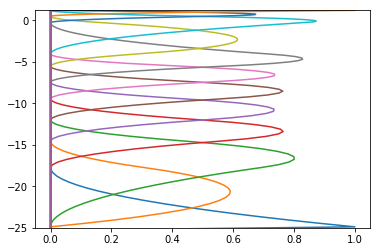

In [5]:
s_misfit = []
s_list = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
Nparams = []
for s in s_list:
    tz1D,cz1D,kz=interpolate.splrep(zspline,psi_z_profile[z>z_cutoff],k=2,s=s)
    misfit = (integrate.simps((psi_z_profile - interpolate.splev(z,(tz1D,cz1D,kz),ext=1))**2,x=z)/
            integrate.simps(psi_z_profile**2,x=z))
    s_misfit.append(misfit*100)
    Nparams.append(tz1D.size-kz-1)

f=interpolate.interp1d(s_misfit,s_list)
smoothing_par = f(0.005).item()
np.set_printoptions(precision=3)
print("Smoothing param at 0.1% level {:.1E}".format(smoothing_par))

tz1D,cz1D,kz=interpolate.splrep(zspline,psi_z_profile[z>z_cutoff],k=2,s=smoothing_par)
print("Number of knots:",tz1D.size)
print("Number of coeffs:",tz1D.size-kz-1)

for i in range(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i = interpolate.splev(z,(tz1D,c_i,kz),ext=1)
    plt.plot(b_i,z)
    plt.ylim(z_cutoff,z[-1])

In [6]:
print(', '.join("{:.1f}".format(knot) for knot in tz1D))

-24.9, -24.9, -24.9, -17.7, -14.6, -12.0, -9.5, -7.5, -5.5, -4.1, -0.3, 0.5, 1.2, 1.2, 1.2


### Determine the coefficient that corresponds to the surface

c surf cutoff index 9
9 parameters to  be fit along z, 6 parameters clamped, 
Coeffs below surface [ 4.011e-05 -3.478e-04  1.450e-03  3.325e-02  1.071e-01  1.451e-01
  1.190e-01  6.977e-02  1.146e-02]
Deep z cutoff ind 0


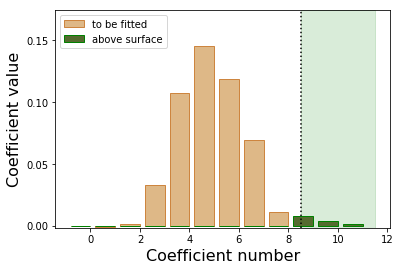

In [8]:
b_i_surf = np.zeros_like(cz1D)
deep_z_cutoff = z_cutoff + 2
b_i_deep = np.zeros_like(cz1D)

for i in range(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i_surf[i] = interpolate.splev(0,(tz1D,c_i,kz))
    b_i_deep[i] = interpolate.splev(deep_z_cutoff,(tz1D,c_i,kz))

c_surf_cutoff = b_i_surf.argmax()
print("c surf cutoff index",c_surf_cutoff)
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]
print("{:d} parameters to  be fit along z, {:d} parameters clamped, "
      .format(c_surf_cutoff,tz1D.size - c_surf_cutoff))
print("Coeffs below surface",cz1D[:c_surf_cutoff])

deep_z_cutoff_ind = b_i_deep.argmax()
print("Deep z cutoff ind",deep_z_cutoff_ind)

plt.bar(np.arange(cz1D_bottom.size-kz-1)-0.4,cz1D_bottom[:-(kz+1)],width=0.8,
            facecolor='burlywood',edgecolor='peru',zorder=1,label="to be fitted");
plt.bar(np.arange(cz1D_top.size-(kz+1))-0.4,cz1D_top[:-(kz+1)],width=0.8,facecolor='darkolivegreen',
        edgecolor='green',label="above surface",zorder=2);
plt.axvline(c_surf_cutoff-0.5,color="black",ls="dotted");
plt.axvspan(c_surf_cutoff-0.5,cz1D_bottom.size-0.5-(kz+1),color="green",alpha=0.15,zorder=0)
plt.ylim(cz1D_bottom.min()-0.001,cz1D_bottom.max()*1.2);
plt.legend(loc="best")
plt.ylabel("Coefficient value",fontsize=16)
plt.xlabel("Coefficient number",fontsize=16);
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
# if not os.path.exists("plots"): os.makedirs("plots")
# plt.savefig("plots/psi_spline_coeffs.eps")

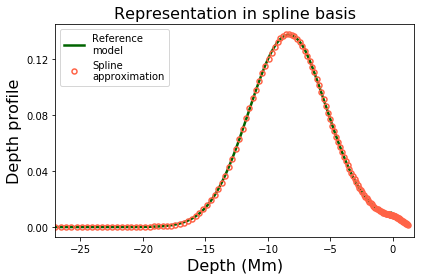

In [9]:
psi_spl_fit_top=interpolate.splev(z,(tz1D,cz1D_top,kz),ext=1);
psi_spl_fit_bottom=interpolate.splev(z,(tz1D,cz1D_bottom,kz),ext=1);

plt.plot(z,psi_z_profile,linewidth=2.5,color="darkgreen",label="Reference\nmodel");
plt.plot(z,psi_spl_fit_top+psi_spl_fit_bottom,ls="None",marker='o',
         markersize=5,mec="tomato",mfc="None",mew=1.5,label="Spline\napproximation");

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))

plt.xlim(z_cutoff-2,z[-1]+0.5);
plt.legend(loc="best")

plt.title("Representation in spline basis",fontsize=16)
plt.xlabel("Depth (Mm)",fontsize=16)
plt.ylabel("Depth profile",fontsize=16)

plt.tight_layout()

# if not os.path.exists("plots"): os.makedirs("plots")
# plt.savefig("plots/spline_fit_to_psi.eps")

### True (spline fit) and starting model

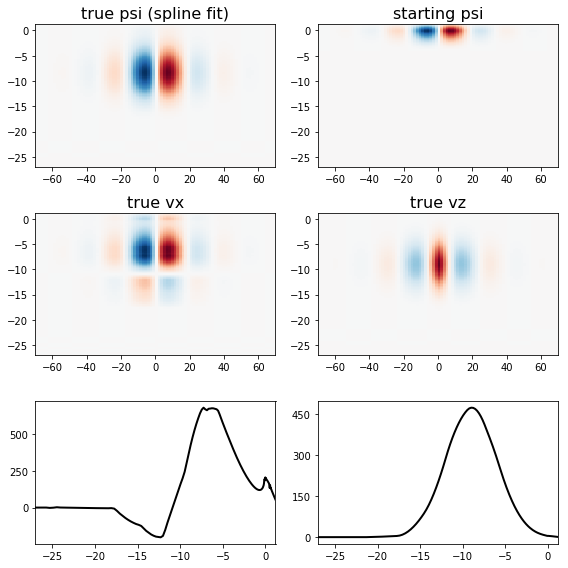

In [10]:
psi_spline = coeff_to_model((tz1D,cz1D_top+cz1D_bottom,kz))
psi_spline_surf = coeff_to_model((tz1D,cz1D_top,kz))

vx_spline = -dbyd2.dbyd2(rho*c_sound*psi_spline.T,1)/dbyd2.dbyd2(np.atleast_2d(z),1)/rho
vx_spline = vx_spline.T
vz_spline = np.zeros_like(psi_spline)
for rowno,row in enumerate(psi_spline):
    vz_spline[rowno] = fftpack.diff(row,period=Lx)*c_sound[rowno]

fig,axes = plt.subplots(3,2)
axes = axes.flatten()

vmax = abs(psi_spline).max()
axes[0].pcolormesh(x,z,psi_spline,vmin=-vmax,vmax=vmax,cmap="RdBu_r");
axes[0].set_title('true psi (spline fit)',fontsize=16)

vmax = abs(psi_spline_surf).max()
axes[1].pcolormesh(x,z,psi_spline_surf,vmin=-vmax,vmax=vmax,cmap="RdBu_r");
axes[1].set_title('starting psi',fontsize=16)

vmax = abs(vx_spline).max()
axes[2].pcolormesh(x,z,vx_spline,vmin=-vmax,vmax=vmax,cmap="RdBu_r");
axes[2].set_title('true vx',fontsize=16)

vmax = abs(vz_spline).max()
axes[3].pcolormesh(x,z,vz_spline,vmin=-vmax,vmax=vmax,cmap="RdBu_r");
axes[3].set_title('true vz',fontsize=16)

for ax in axes[:4]:
    ax.set_xlim(-70,70)
    ax.set_ylim(z_cutoff-2,z[-1])

_,vx_peak_x = np.unravel_index(vx_spline.argmax(),vx_spline.shape)
axes[4].plot(z,vx_spline[:,vx_peak_x],lw=2,color="black")
axes[4].set_xlim(z_cutoff-2,z[-1])
axes[4].yaxis.set_major_locator(ticker.MaxNLocator(4))

_,vz_peak_x = np.unravel_index(vz_spline.argmax(),vz_spline.shape)
axes[5].plot(z,vz_spline[:,vz_peak_x],lw=2,color="black")
axes[5].set_xlim(z_cutoff-2,z[-1])
axes[5].yaxis.set_major_locator(ticker.MaxNLocator(4))

plt.gcf().set_size_inches(8,8)
plt.tight_layout()

### Surface and peak values

In [11]:
def peak_and_surf_vel(v_arr,label="v"):
    v_peak_z,v_peak_x = np.unravel_index(v_arr.argmax(),v_arr.shape)
    print("{} peak velocity at z={:.1f} Mm, magnitude {:.1f} m/s".format(label,z[v_peak_z],v_arr[v_peak_z,v_peak_x]))
    print("{} peak surface velocity {:.1f} m/s".format(label,v_arr[abs(z).argmin(),v_peak_x]))

peak_and_surf_vel(vx_spline,label="vx")
peak_and_surf_vel(vz_spline,label="vz")

vx peak velocity at z=-7.3 Mm, magnitude 677.3 m/s
vx peak surface velocity 205.2 m/s
vz peak velocity at z=-9.0 Mm, magnitude 474.8 m/s
vz peak surface velocity 5.0 m/s


In [12]:
import read_params

datadir = Path(read_params.get_directory())

if datadir.exists():
    fits.writeto(datadir/"model_psi_ls00.fits", psi_spline_surf[:,np.newaxis,:],overwrite=True)

    shutil.copyfile(datadir/"model_psi_ls00.fits", datadir/"model_psi_ls00_start.fits")

    np.savez(datadir/"model_psi_ls00_coeffs.npz",z=np.zeros_like(cz1D))

    shutil.copyfile(datadir/"model_psi_ls00_coeffs.npz", datadir/"model_psi_ls00_coeffs_start.npz")

else:
    print(datadir,"doesn't exist, not writing out starting models")
    
np.savez("true_psi_coeffs.npz",tz=tz1D,kz=kz,
        cz_top=cz1D_top,cz_bot=cz1D_bottom,c_surf_cutoff=c_surf_cutoff,z_cutoff = z_cutoff,
            deep_z_cutoff_ind=deep_z_cutoff_ind)
fits.writeto("true_psi.fits",psi_spline,overwrite=True)
fits.writeto("true_vx.fits",vx_spline,overwrite=True)
fits.writeto("true_vz.fits",vz_spline,overwrite=True)

/scratch/jishnu/flows/spline_SG1_filter doesn't exist, not writing out starting models
